# 处理时间序列数据

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras

## 抽取数据

In [3]:
data = pd.read_csv('jena_climate_2009_2016.csv')

In [4]:
data

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


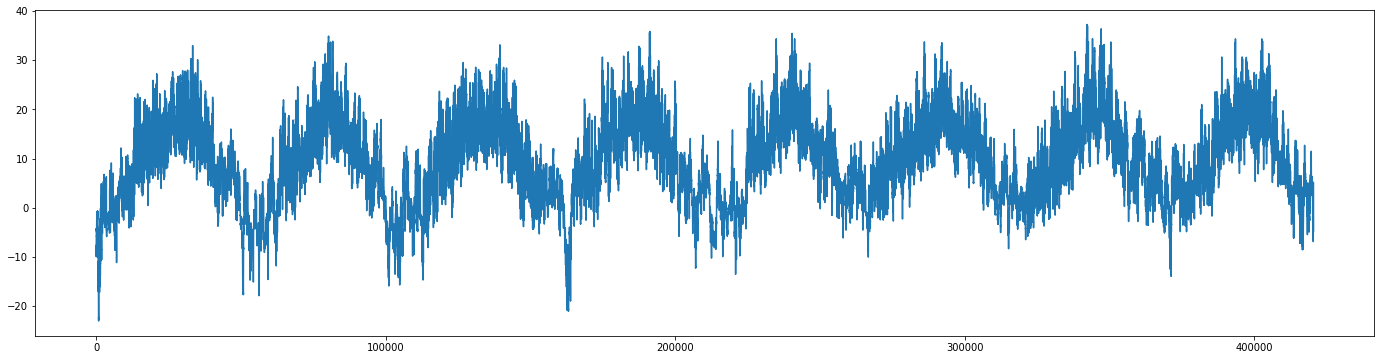

In [5]:
data.loc[:, 'T (degC)'].plot(figsize=(24,6))

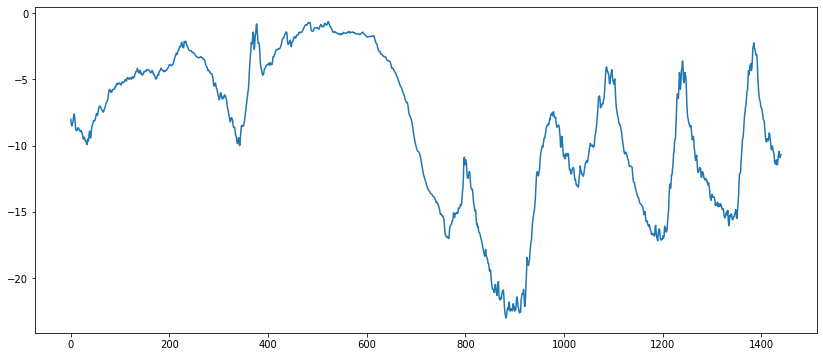

In [6]:
data.loc[:1440, 'T (degC)'].plot(figsize=(14,6))

#### 数据说明
1. 每10分钟采集一次 
2. 24小时内会有144条数据

In [7]:
### 数据标准化
float_data = data.iloc[:,1:].copy().values
mean = float_data[:20000].mean(axis=0)
float_data -= mean
std = float_data[:20000].std(axis=0)
float_data /= std

In [8]:
### 参数
lookback = 720   # 5天的观察数据
steps=6          #观察数据采样平率是每个小时一个数据点
delay=144        # 目标是未来24小时之后的数据
batch_size = 128

In [9]:
def generate(data, lookback, delay, min_index, max_index, shuffle=False, batch_size = 128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index+lookback
            rows = np.arange(i, min(i+ batch_size, max_index))
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
train_gen = generate(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index = 0,
                    max_index=200000,
                    shuffle=True,
                    step = steps,
                    batch_size = batch_size)
val_gen = generate(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index = 200001,
                    max_index=300000,
                    shuffle=True,
                    step = steps,
                    batch_size = batch_size)
test_gen = generate(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index = 300001,
                    max_index=None,
                    shuffle=True,
                    step = steps,
                    batch_size = batch_size)

In [11]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 基准

In [12]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)
mae_stand = evaluate_naive_method()
print(f"mae T : {mae_stand * std[1]}")

mae T : 2.564456149193549


### 1. 使用密集链接模型

In [13]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(lookback//steps, float_data.shape[-1])),
    keras.layers.Dense(32, activation ='relu'),
    keras.layers.Dense(1)
])

In [14]:
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='mae')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1680)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                53792     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(train_gen,
                   steps_per_epoch=500,
                   epochs=20,
                   validation_data = val_gen,
                   validation_steps = val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 775 steps
Epoch 1/20
500/500 [==============================] - 6s 12ms/step - loss: 0.7965 - val_loss: 0.7176
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.4299 - val_loss: 0.3455
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3499 - val_loss: 0.3496
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3213 - val_loss: 0.3495
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3044 - val_loss: 0.3467
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2919 - val_loss: 0.3876
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2848 - val_loss: 0.3761
Epoch 8/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2806 - val_loss: 0.3502
Epoch 9/20
500/500 [==

In [27]:
def show_history(history, epochs):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs-1)

    plt.figure(figsize=(12, 8))
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(epochs_range, loss[1:],'bo', label='Training Loss')
    ax1.plot(epochs_range, val_loss[1:],'r', label='Validation Loss')
    ax1.legend(loc='upper right')
    ax1.set_title('Training and Validation Loss')

    plt.show()

In [28]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

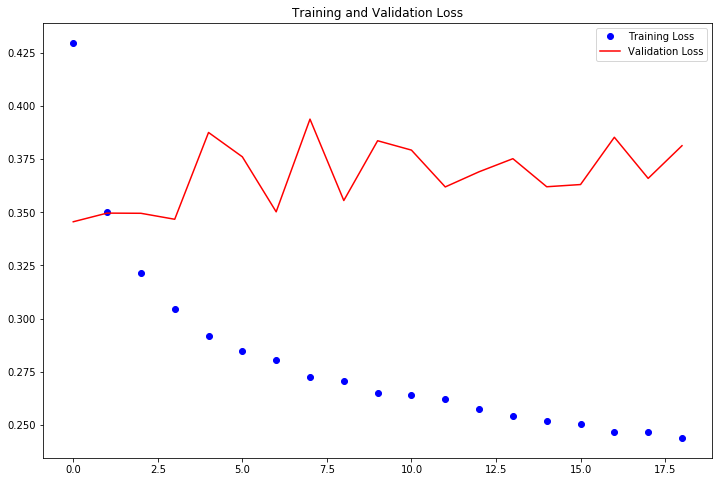

In [29]:
show_history(history, 20)

### 2. GRU循环网络

In [31]:
model_GRU = keras.Sequential([
    keras.layers.GRU(32, input_shape=(None, float_data.shape[-1])),
    keras.layers.Dense(1)
])

In [32]:
model_GRU.compile(optimizer=keras.optimizers.RMSprop(),
             loss='mae')

In [34]:
history = model_GRU.fit(train_gen,
                   steps_per_epoch=500,
                   epochs=20,
                   validation_data = val_gen,
                   validation_steps = val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 775 steps
Epoch 1/20
500/500 [==============================] - 32s 64ms/step - loss: 0.3547 - val_loss: 0.3166
Epoch 2/20
500/500 [==============================] - 34s 69ms/step - loss: 0.3309 - val_loss: 0.3104
Epoch 3/20
500/500 [==============================] - 33s 67ms/step - loss: 0.3210 - val_loss: 0.3073
Epoch 4/20
500/500 [==============================] - 33s 66ms/step - loss: 0.3128 - val_loss: 0.3093
Epoch 5/20
500/500 [==============================] - 33s 66ms/step - loss: 0.3075 - val_loss: 0.3087
Epoch 6/20
500/500 [==============================] - 33s 65ms/step - loss: 0.3022 - val_loss: 0.3112
Epoch 7/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2939 - val_loss: 0.3132
Epoch 8/20
500/500 [==============================] - 34s 67ms/step - loss: 0.2918 - val_loss: 0.3103
Epoch 9/20
500/500 [==============================] - 34s 68ms/step - loss: 0.2858 - val_l

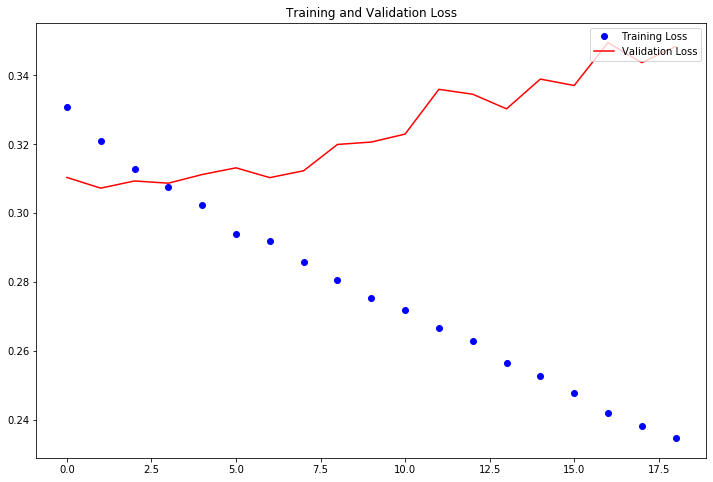

In [35]:
show_history(history, 20)

### 3.使用dropout

In [40]:
model_GRU = keras.Sequential([
    keras.layers.GRU(32, dropout=0.2, recurrent_dropout = 0.2,
                     input_shape=(None, float_data.shape[-1])),
    keras.layers.Dense(1)
])

In [41]:
model_GRU.compile(optimizer=keras.optimizers.RMSprop(),
             loss='mae')

In [42]:
history = model_GRU.fit(train_gen,
                   steps_per_epoch=500,
                   epochs=40,
                   validation_data = val_gen,
                   validation_steps = val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 775 steps
Epoch 1/40
500/500 [==============================] - 54s 109ms/step - loss: 0.4059 - val_loss: 0.3229
Epoch 2/40
500/500 [==============================] - 53s 107ms/step - loss: 0.3596 - val_loss: 0.3184
Epoch 3/40
500/500 [==============================] - 51s 103ms/step - loss: 0.3490 - val_loss: 0.3120
Epoch 4/40
500/500 [==============================] - 51s 102ms/step - loss: 0.3454 - val_loss: 0.3154
Epoch 5/40
500/500 [==============================] - 50s 101ms/step - loss: 0.3397 - val_loss: 0.3130
Epoch 6/40
500/500 [==============================] - 52s 104ms/step - loss: 0.3348 - val_loss: 0.3108
Epoch 7/40
500/500 [==============================] - 53s 105ms/step - loss: 0.3327 - val_loss: 0.3116
Epoch 8/40
500/500 [==============================] - 52s 105ms/step - loss: 0.3283 - val_loss: 0.3109
Epoch 9/40
500/500 [==============================] - 52s 104ms/step - loss: 0.326

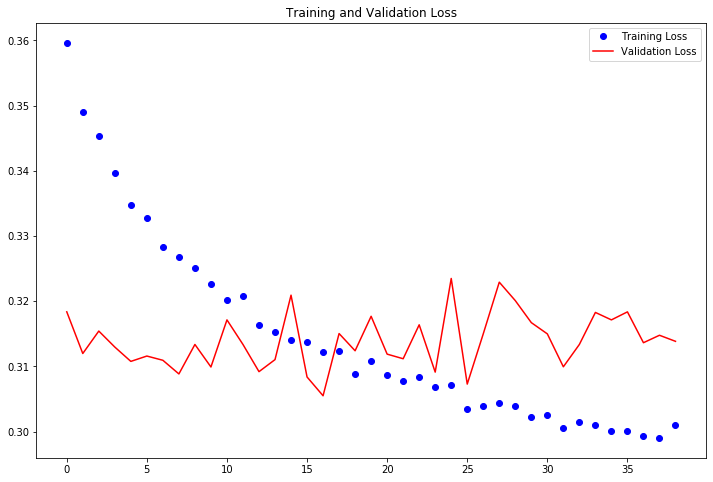

In [44]:
show_history(history, 40)

### 4.增加容量

In [46]:
model_GRU = keras.Sequential([
    keras.layers.GRU(32, dropout=0.1, recurrent_dropout = 0.5,return_sequences=True,
                     input_shape=(None, float_data.shape[-1])),
    keras.layers.GRU(64, dropout=0.1, recurrent_dropout = 0.5,
                     activation='relu'),
    keras.layers.Dense(1)
])

In [47]:
model_GRU.compile(optimizer=keras.optimizers.RMSprop(),
             loss='mae')

In [48]:
history = model_GRU.fit(train_gen,
                   steps_per_epoch=500,
                   epochs=40,
                   validation_data = val_gen,
                   validation_steps = val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 775 steps
Epoch 1/40
500/500 [==============================] - 118s 236ms/step - loss: 0.3844 - val_loss: 0.3242
Epoch 2/40
500/500 [==============================] - 113s 227ms/step - loss: 0.3588 - val_loss: 0.3192
Epoch 3/40
500/500 [==============================] - 113s 226ms/step - loss: 0.3521 - val_loss: 0.3174
Epoch 4/40
500/500 [==============================] - 115s 230ms/step - loss: 0.3474 - val_loss: 0.3100
Epoch 5/40
500/500 [==============================] - 115s 230ms/step - loss: 0.3405 - val_loss: 0.3066
Epoch 6/40
500/500 [==============================] - 114s 229ms/step - loss: 0.3356 - val_loss: 0.3062
Epoch 7/40
500/500 [==============================] - 112s 225ms/step - loss: 0.3340 - val_loss: 0.3119
Epoch 8/40
500/500 [==============================] - 112s 224ms/step - loss: 0.3270 - val_loss: 0.3020
Epoch 9/40
500/500 [==============================] - 111s 223ms/step - lo

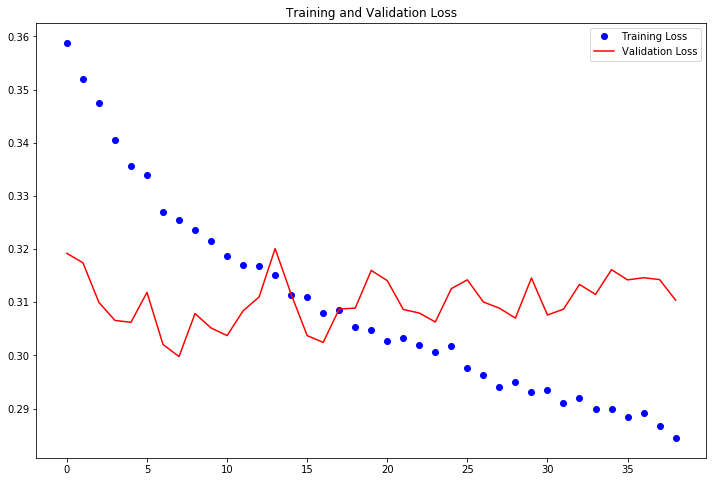

In [49]:
show_history(history, 40)

### 5.使用双向GRU

In [50]:
model_BiGRU = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.GRU(32),
                     input_shape=(None, float_data.shape[-1])),
    keras.layers.Dense(1)
])

In [52]:
model_BiGRU.compile(optimizer=keras.optimizers.RMSprop(),
             loss='mae')

In [53]:
history = model_GRU.fit(train_gen,
                   steps_per_epoch=500,
                   epochs=40,
                   validation_data = val_gen,
                   validation_steps = val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 775 steps
Epoch 1/40
500/500 [==============================] - 116s 233ms/step - loss: 0.2845 - val_loss: 0.3164
Epoch 2/40
500/500 [==============================] - 112s 223ms/step - loss: 0.2841 - val_loss: 0.3137
Epoch 3/40
500/500 [==============================] - 113s 226ms/step - loss: 0.2830 - val_loss: 0.3153
Epoch 4/40
500/500 [==============================] - 114s 228ms/step - loss: 0.2820 - val_loss: 0.3103
Epoch 5/40
500/500 [==============================] - 111s 223ms/step - loss: 0.2825 - val_loss: 0.3178
Epoch 6/40
500/500 [==============================] - 111s 222ms/step - loss: 0.2815 - val_loss: 0.3115
Epoch 7/40
500/500 [==============================] - 111s 222ms/step - loss: 0.2815 - val_loss: 0.3113
Epoch 8/40
500/500 [==============================] - 111s 223ms/step - loss: 0.2806 - val_loss: 0.3151
Epoch 9/40
500/500 [==============================] - 111s 222ms/step - lo

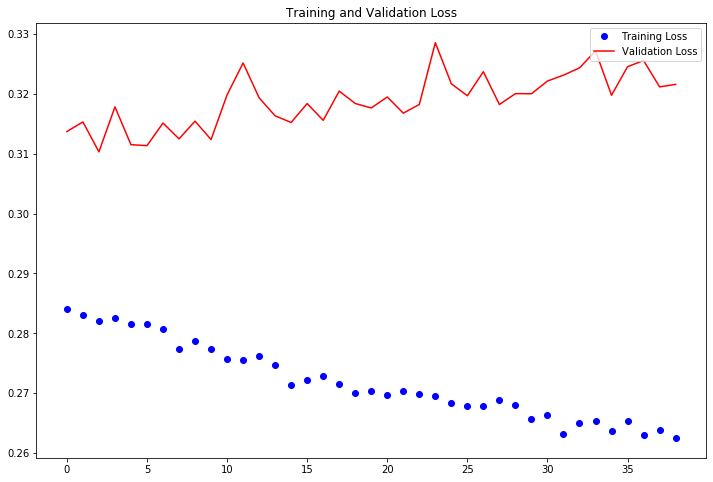

In [54]:
show_history(history, 40)